Recommendations systems task

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import zipfile
import requests
import os

from scipy import spatial
from tensorflow import feature_column
from tensorflow.keras import layers

from matplotlib import pyplot as plt


In [2]:
def download_url(url, save_path, chunk_size=128):
    r = requests.get(url, stream=True)
    with open(save_path, 'wb') as fd:
        for chunk in r.iter_content(chunk_size=chunk_size):
            fd.write(chunk)



In [3]:
# data collection, preparation and first look

In [4]:
cwd = os.getcwd()

In [5]:
download_url("http://files.grouplens.org/datasets/movielens/ml-100k.zip", "df.zip")

In [6]:
with zipfile.ZipFile("df.zip", 'r') as zip_ref:
    zip_ref.extractall(cwd)

In [7]:
names=['user_id', 'movie_id', 'rating','unix_timestamp']
udata = pd.read_csv(os.path.join(cwd, 'ml-100k/u.data'), '\t', names=names,
                       engine='python')

In [8]:
print("shape ", udata.shape)
udata.head()

shape  (100000, 4)


,user_id,movie_id,rating,unix_timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [9]:
m_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
uitem = pd.read_csv('ml-100k/u.item', sep='|', names=m_cols, usecols=range(5),
                     encoding='latin-1')

In [10]:
print("shape ", uitem.shape)
uitem.head()

shape  (1682, 5)


,movie_id,title,release_date,video_release_date,imdb_url
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995)


In [11]:
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=u_cols,
                    encoding='latin-1')


In [12]:
print("shape ", users.shape)
users.head()

shape  (943, 5)


,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [13]:
# basic statistics

In [14]:
udata["rating"].describe()

count    100000.000000
mean          3.529860
std           1.125674
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

In [15]:
users["age"].describe()

count    943.000000
mean      34.051962
std       12.192740
min        7.000000
25%       25.000000
50%       31.000000
75%       43.000000
max       73.000000
Name: age, dtype: float64

In [16]:
udata["movie_id"].describe()['max']

1682.0

In [17]:
movies_voted = udata.groupby('movie_id')['rating'].agg('count') # number of ratings for movie_id 
user_voted = udata.groupby('user_id')['rating'].agg('count') # number of rated movies for user_id

Text(0.5, 1.0, 'Number of Ratings per movie')

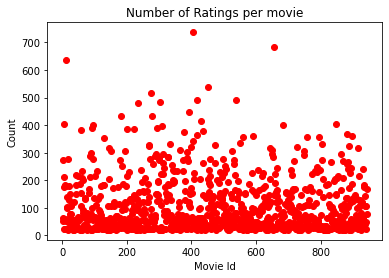

In [18]:
plt.scatter(user_voted.index,user_voted,color='red') # plot of number of votes vs movie id
plt.xlabel('Movie Id')
plt.ylabel('Count')
plt.title('Number of Ratings per movie')

Text(0.5, 1.0, 'Number of Ratings per user')

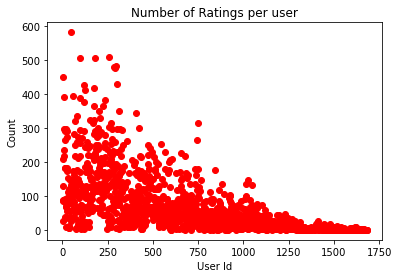

In [19]:
plt.scatter(movies_voted.index,movies_voted,color='red') # plot of votes vs user id 
plt.xlabel('User Id')
plt.ylabel('Count')
plt.title('Number of Ratings per user')

Text(0.5, 1.0, 'Distribution of Ratings in Movies')

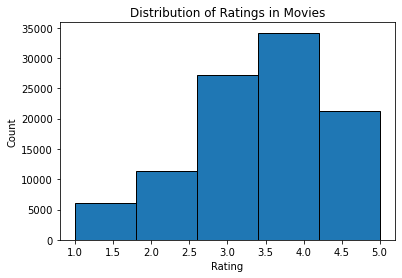

In [20]:
plt.hist(udata['rating'], bins=5, ec='black')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings in Movies')

In [21]:
# data splitting

In [22]:
train_set = udata.sample(frac = 0.8) 
test_set = udata.drop(train_set.index) 

In [23]:
# implement memory base system

In [24]:
# user item matrix
rating_user = train_set.pivot(index='user_id',columns='movie_id',values='rating')
rating_user.fillna(0,inplace=True)
rating_user.head(10)

movie_id,1,2,3,4,5,6,7,8,9,10,...,1669,1670,1672,1673,1674,1675,1677,1678,1680,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,0.0,3.0,5.0,4.0,1.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,5.0,0.0,0.0,5.0,5.0,5.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,5.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
rating_user.shape

(943, 1646)

In [26]:
udata["user_id"].describe()['max']

943.0

In [27]:
#sparsity
sparsity = 1.0 - ( np.count_nonzero(rating_user) / float(rating_user.size) )
print(sparsity)

0.9484595194623298


In [28]:
# user to user similarity matrix
res = np.zeros((rating_user.shape[0],rating_user.shape[0]))
for index1, row1 in rating_user.iterrows():
    for index2, row2 in rating_user.iterrows():
        if index1>=index2:
            res[index1-1,index2-1] = spatial.distance.cosine(row1, row2)
            res[index2-1,index1-1] = res[index1-1,index2-1]
user_user_similarity  = pd.DataFrame(res)
user_user_similarity.head()


,0,1,2,3,4,5,6,7,8,9,...,933,934,935,936,937,938,939,940,941,942
0,0.000000,0.895501,0.961480,0.921067,0.712433,0.647251,0.617591,0.747066,0.907468,0.685763,...,0.730913,0.908229,0.784476,0.850464,0.857240,0.910901,0.784903,0.875505,0.856868,0.683011
1,0.895501,0.000000,0.950082,0.880810,0.943512,0.805855,0.961794,0.914682,0.882187,0.888742,...,0.903881,0.752503,0.749273,0.658263,0.726731,0.757841,0.844382,0.848500,0.852665,0.913757
2,0.961480,0.950082,0.000000,0.831824,0.972848,0.951840,0.957033,0.939937,0.926005,0.928125,...,0.973002,0.964705,0.857234,0.964254,0.902553,0.981376,0.874020,0.914788,0.874217,0.966837
3,0.921067,0.880810,0.831824,0.000000,0.960579,0.947674,0.921712,0.814271,0.880926,0.924034,...,0.977473,1.000000,0.944119,0.785245,0.828459,0.962704,0.817093,0.865922,0.878499,0.947819
4,0.712433,0.943512,0.972848,0.960579,0.000000,0.827726,0.705050,0.754973,0.931967,0.831119,...,0.751183,0.951323,0.923628,0.923625,0.900907,0.955969,0.811363,0.843307,0.850725,0.745490


Model for prediction is based on user-user similarity matrix. The algorithm checks how similar users rated movie and returns average of topx values. 

In [29]:
# predict function for user - user similarity
def predict_user_based(item_index,user_index,user_similarity_mx,rating_user,topx=5):
    top_similar = user_similarity_mx.iloc[user_index-1].sort_values().index
    indx = 0
    top_x_similar_rating = []
    while(len(top_x_similar_rating)<topx):
        if indx >= len(user_user_similarity) and len(top_x_similar_rating)>0:
            return top_x_similar_rating
        else:
            return 3                
        usr_ind = top_similar[indx]
        indx+=1
        if rating_user.iat[usr_ind+1,item_index]!=0:
            top_x_similar_rating.append(rating_user.iat[usr_ind+1,item_index])
   
    return sum(top_ten_similar_rating) / len(top_ten_similar_rating)
    #return np.around(sum(top_ten_similar_rating) / len(top_ten_similar_rating))

In [30]:
# root mean square error on test set 
mse = 0
for index in range(len(test_set)):
    pred_rating = predict_user_based(test_set.iloc[index]['movie_id'],test_set.iloc[index]['user_id'] ,user_user_similarity,rating_user)
    rating_diff = (test_set.iloc[index]['rating']-pred_rating)**2
    mse+=rating_diff
mse=mse/len(test_set)

In [31]:
# value of rmse
print(mse)

1.5529


In [32]:
rating_movie = train_set.pivot(index='movie_id',columns='user_id',values='rating')
rating_movie.fillna(0,inplace=True)
rating_movie.head(10)

user_id,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
movie_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,4.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0,4.0,...,2.0,0.0,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0
2,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,4.0,0.0,0.0,0.0,0.0,2.0,5.0,3.0,4.0,4.0,...,0.0,0.0,4.0,0.0,4.0,0.0,4.0,0.0,0.0,0.0
8,1.0,0.0,0.0,0.0,0.0,4.0,5.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0
9,5.0,0.0,0.0,0.0,0.0,4.0,5.0,0.0,0.0,0.0,...,0.0,1.0,4.0,5.0,0.0,0.0,3.0,0.0,0.0,3.0


In [33]:
rating_movie = rating_movie.reindex(list(range(0,int(udata["movie_id"].describe()['max']))),fill_value=0)
#fill missing values in movie_id

In [34]:
rating_movie.shape

(1682, 943)

In [35]:
udata["movie_id"].describe()['max']

1682.0

In [36]:
# item to item similarity matrix
res_movie = np.zeros((rating_movie.shape[0],rating_movie.shape[0]))
for index1, (_, row1) in enumerate(rating_movie.iterrows()):
    for index2, (_, row2) in enumerate(rating_movie.iterrows()):

        if index1>=index2:
            res_movie[index1-1,index2-1] = spatial.distance.cosine(row1, row2)
            res_movie[index2-1,index1-1] = res_movie[index1-1,index2-1]
item_item_similarity  = pd.DataFrame(res_movie)
item_item_similarity.fillna(0,inplace=True)
item_item_similarity.head()


/home/solar/anaconda3/lib/python3.8/site-packages/scipy/spatial/distance.py:714: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


,0,1,2,3,4,5,6,7,8,9,...,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681
0,0.000000,0.653250,0.685586,0.633842,0.760350,0.863789,0.477418,0.588721,0.621686,0.801937,...,0.960243,1.0,1.000000,0.0,1.000000,1.0,0.0,1.0,0.0,0.0
1,0.653250,0.000000,0.761136,0.615160,0.734031,0.946439,0.685829,0.710643,0.773106,0.905052,...,1.000000,1.0,1.000000,0.0,1.000000,1.0,0.0,1.0,0.0,0.0
2,0.685586,0.761136,0.000000,0.745435,0.803524,0.875949,0.684147,0.851946,0.753537,0.891660,...,1.000000,1.0,1.000000,0.0,0.964376,1.0,0.0,1.0,0.0,0.0
3,0.633842,0.615160,0.745435,0.000000,0.717899,0.966653,0.613957,0.597456,0.666827,0.769683,...,1.000000,1.0,0.893976,0.0,0.957591,1.0,0.0,1.0,0.0,0.0
4,0.760350,0.734031,0.803524,0.717899,0.000000,0.956820,0.715598,0.801019,0.771440,0.972891,...,1.000000,1.0,1.000000,0.0,1.000000,1.0,0.0,1.0,0.0,0.0


Model for prediction is based on item-item similarity matrix. The predict method returns average of most similar movie.

In [37]:
def predict_item_based(item_index,item_similarity_mx,t_set):

    top_similar = item_similarity_mx.iloc[item_index-1].sort_values().index
    if len(top_similar)>1:
        all_occureces_id = t_set.loc[t_set['movie_id'] == top_similar[1]+1]
        avg_ratings = t_set["rating"].mean()
    else:
        return 3
        #print(top_ten_similar_rating)
    return np.around(avg_ratings)

In [38]:
# root mean square error on test set 
mse = 0
for index,_ in enumerate(test_set.iterrows()):
    pred_rating = predict_item_based(test_set.iloc[index]['movie_id'],item_item_similarity,train_set)
    rating_diff = (test_set.iloc[index]['rating']-pred_rating)**2
    mse+=rating_diff
mse=mse/len(test_set)

In [40]:
mse

1.4667

Apparently item-item approach did slightly better (rmse = 1.4667) than user-user approach (1.5529). There are however few things that can be optimized like topx parameter and maybe resignation from rounding ratings to integes.

This problem has a large bibliography. One of the things that improves prediction is to use Collaborative Filtering.
Model can be improved also increasing the number of features including not only ratings but director , genre, main actor/actress and year of production.Final step might be use of neural network.